In [6]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!conda install -c conda-forge folium

import os
import folium # map rendering library
# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.10.1              |             py_0          59 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    branca:          0.3.1-py_0        conda-forge
    folium:          

In [49]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [50]:
def get_venues(lat,lng):
    
    #set variables
    radius=10000
    LIMIT=100
    CLIENT_ID = 'OXVWX1E4UIBUTICPDBIE1MAMJGG4K4BNT1YGOIEROBTOLJNS'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='ACD4VK0GSOZKCMGZOIA2YJGFYX5FGIEPKKFAEEWJQWTYQS0I' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [51]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'OXVWX1E4UIBUTICPDBIE1MAMJGG4K4BNT1YGOIEROBTOLJNS'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='ACD4VK0GSOZKCMGZOIA2YJGFYX5FGIEPKKFAEEWJQWTYQS0I' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [52]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [53]:
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [54]:
new_york_data.shape

(306, 4)

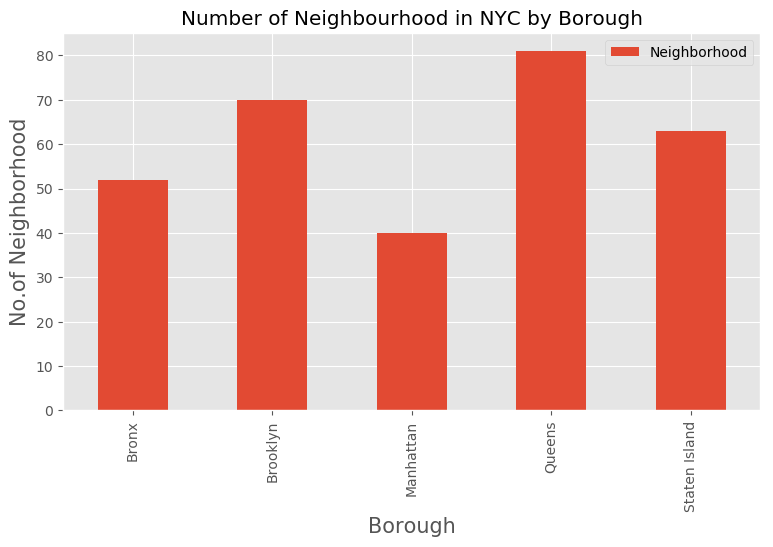

In [55]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighbourhood in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

In [56]:
# prepare neighborhood list that contains asian restaurant
column_names=['Borough', 'Neighborhood', 'ID','Name']
asian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    asian_resturants=venues[venues['Category']=='Asian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Asian Resturants in '+Neighborhood+', '+Borough+':'+str(len(filipino_resturants)))
    for resturant_detail in asian_resturants.values.tolist():
        id, name , category=resturant_detail
        asian_rest_ny = asian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Asian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Asian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Asian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Asian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Asian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Asian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Asian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Asian Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Asian Resturants in Norwood, Bronx:0
( 10 / 306 ) Asian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Asian Resturants in Baychester, Bronx:0
( 12 / 306 ) Asian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Asian Resturants in City Island, Bronx:0
( 14 / 306 ) Asian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Asian Resturants in University Heights, Bronx:0
( 16 / 306 ) Asian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Asian Resturants in Fordham, Bronx:0
( 18 / 306 ) Asian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Asian Resturants in W

In [57]:
asian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Bensonhurst,4b280f8cf964a520698e24e3,Cafe Kashkar
1,Brooklyn,Gravesend,4b280f8cf964a520698e24e3,Cafe Kashkar
2,Brooklyn,Brighton Beach,4b280f8cf964a520698e24e3,Cafe Kashkar
3,Brooklyn,Sheepshead Bay,4b280f8cf964a520698e24e3,Cafe Kashkar
4,Brooklyn,Manhattan Terrace,4b280f8cf964a520698e24e3,Cafe Kashkar


In [59]:
asian_rest_ny.shape

(32, 4)

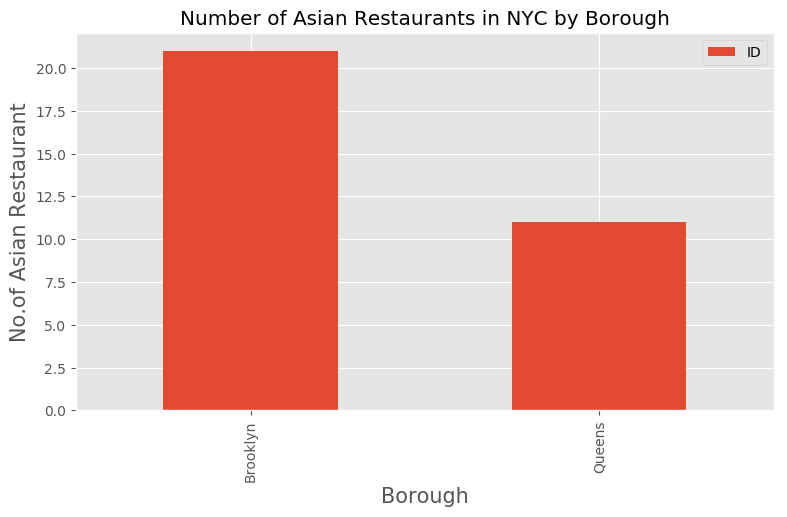

In [60]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Asian Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Asian Restaurant', fontsize=15)
#giving a bar plot
asian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [64]:
asian_rest_ny[asian_rest_ny['Borough']=='Brooklyn']

,Borough,Neighborhood,ID,Name
0,Brooklyn,Bensonhurst,4b280f8cf964a520698e24e3,Cafe Kashkar
1,Brooklyn,Gravesend,4b280f8cf964a520698e24e3,Cafe Kashkar
2,Brooklyn,Brighton Beach,4b280f8cf964a520698e24e3,Cafe Kashkar
3,Brooklyn,Sheepshead Bay,4b280f8cf964a520698e24e3,Cafe Kashkar
4,Brooklyn,Manhattan Terrace,4b280f8cf964a520698e24e3,Cafe Kashkar
5,Brooklyn,Starrett City,545ecd4b498eefe9c0237723,Little Mo
6,Brooklyn,Mill Island,4b280f8cf964a520698e24e3,Cafe Kashkar
7,Brooklyn,Manhattan Beach,4b280f8cf964a520698e24e3,Cafe Kashkar
8,Brooklyn,Coney Island,4b280f8cf964a520698e24e3,Cafe Kashkar
9,Brooklyn,Bath Beach,4b280f8cf964a520698e24e3,Cafe Kashkar


In [65]:
asian_rest_ny[asian_rest_ny['Borough']=='Queens']

,Borough,Neighborhood,ID,Name
17,Queens,Bayside,4b89832df964a520a23d32e3,Peking Duck Sandwich Stall
18,Queens,Auburndale,4b89832df964a520a23d32e3,Peking Duck Sandwich Stall
19,Queens,Fresh Meadows,4b89832df964a520a23d32e3,Peking Duck Sandwich Stall
20,Queens,Breezy Point,4b280f8cf964a520698e24e3,Cafe Kashkar
21,Queens,Bay Terrace,4b89832df964a520a23d32e3,Peking Duck Sandwich Stall
22,Queens,Neponsit,4b280f8cf964a520698e24e3,Cafe Kashkar
23,Queens,Lindenwood,545ecd4b498eefe9c0237723,Little Mo
24,Queens,Belle Harbor,4b280f8cf964a520698e24e3,Cafe Kashkar
27,Queens,Utopia,4b89832df964a520a23d32e3,Peking Duck Sandwich Stall
28,Queens,Roxbury,4b280f8cf964a520698e24e3,Cafe Kashkar


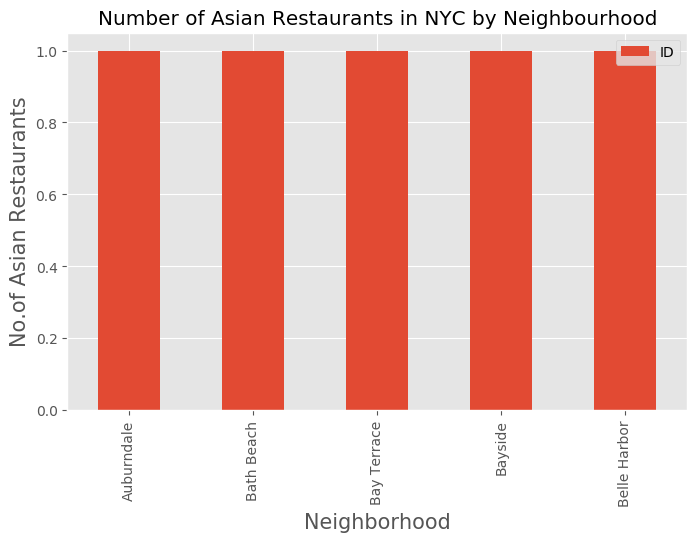

In [67]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(8,5), dpi = 100)
# title
plt.title('Number of Asian Restaurants in NYC by Neighbourhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Asian Restaurants', fontsize=15)
#giving a bar plot
filipino_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [68]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
asian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in asian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains Asian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
asian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in asian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(filipino_rest_ny),')','processed')
    asian_rest_stats_ny = filipino_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID          Name  Likes  Rating  Tips
0  4b280f8cf964a520698e24e3  Cafe Kashkar    110     8.8    40
( 1 / 32 ) processed
                         ID          Name  Likes  Rating  Tips
0  4b280f8cf964a520698e24e3  Cafe Kashkar    110     8.8    40
( 2 / 32 ) processed
                         ID          Name  Likes  Rating  Tips
0  4b280f8cf964a520698e24e3  Cafe Kashkar    110     8.8    40
( 3 / 32 ) processed
                         ID          Name  Likes  Rating  Tips
0  4b280f8cf964a520698e24e3  Cafe Kashkar    110     8.8    40
( 4 / 32 ) processed
                         ID          Name  Likes  Rating  Tips
0  4b280f8cf964a520698e24e3  Cafe Kashkar    110     8.8    40
( 5 / 32 ) processed
                         ID       Name  Likes  Rating  Tips
0  545ecd4b498eefe9c0237723  Little Mo    215     8.9    40
( 6 / 32 ) processed
                         ID          Name  Likes  Rating  Tips
0  4b280f8cf964a520698e24e3  Cafe Kashkar    110     8.8    4

In [69]:
asian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Queens,Queensboro Hill,4aecab47f964a52026ca21e3,Tito Rad's Grill & Restaurant,184.0,8.9,74.0
1,Brooklyn,Madison,4b280f8cf964a520698e24e3,Cafe Kashkar,110.0,8.8,40.0


In [71]:
asian_rest_stats_ny.shape

(2, 7)

In [77]:
asian_rest_stats_ny['Likes']=asian_rest_stats_ny['Likes'].astype('float64')

In [78]:
asian_rest_stats_ny['Tips']=asian_rest_stats_ny['Tips'].astype('float64')

In [79]:
asian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 7 columns):
Borough         2 non-null object
Neighborhood    2 non-null object
ID              2 non-null object
Name            2 non-null object
Likes           2 non-null float64
Rating          2 non-null float64
Tips            2 non-null float64
dtypes: float64(3), object(4)
memory usage: 192.0+ bytes


In [83]:
ny_neighborhood_stats=asian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [84]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
1,Queensboro Hill,8.9
0,Madison,8.8


In [85]:
ny_borough_stats=filipino_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [86]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Queens,8.9


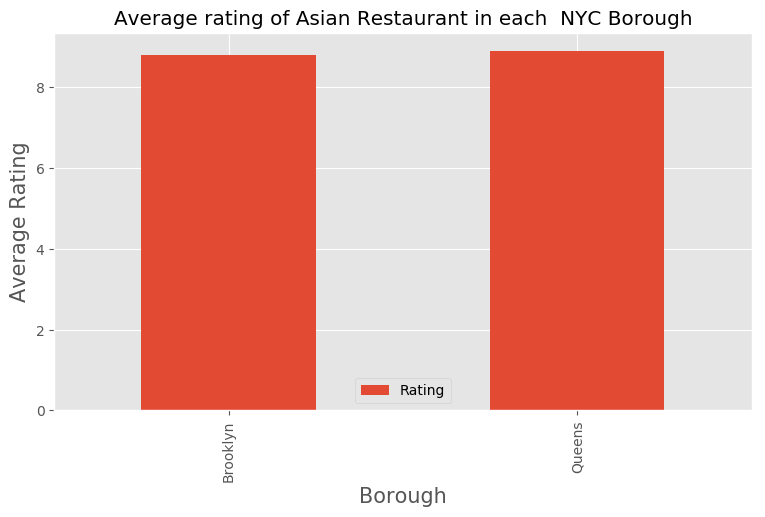

In [87]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Asian Restaurant in each  NYC Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
asian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [88]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [89]:
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Madison,8.8
1,Queensboro Hill,8.9


In [90]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [91]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [92]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Neighborhood,Latitude,Longitude,Average Rating
1,Queens,Queensboro Hill,40.744572,-73.825809,8.9
0,Brooklyn,Madison,40.609378,-73.948415,8.8


In [93]:
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)

In [94]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [95]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [96]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)